(explainer_basicstats)=
Descriptive Statistics
==================


In this section we look further into some basic properties of our network. We will use the node attributes and edgelist from our [Data Collection](explainer_data_collection) notebook. Initially we will model a directed network where each node constitutes a Wikipedia page and each edge constitutes a hyperlink from one page to another. We furthermore subset our network to only include the weakly connected component.


In [10]:
# imports
import pickle
import powerlaw
import warnings
import pandas as pd
import networkx as nx
from fa2 import ForceAtlas2
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib import rc
plt.style.use('science')
set_matplotlib_formats('svg')
rc("text", usetex=False)

from pyvis.network import Network
from bokeh.io import output_notebook, show, save, output_file
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import from_networkx
from bokeh import palettes
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.models import Title
output_notebook()

Loading BokehJS ...

In [11]:
# Load edgelist and node attributes
edgelist = pd.read_pickle("https://drive.google.com/uc?export=download&id=1e3sy-VzJQXP1CozdBviCD5PYgrcWC_dw")
node_attr = pd.read_pickle("https://drive.google.com/uc?export=download&id=1HvB-OQt4P-MXEM7X-fT47_aso9-KL_pK")

# Gather the directed network
G = nx.DiGraph()
G.add_edges_from(edgelist)
nx.set_node_attributes(G, node_attr)
gcc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(gcc)
print(f"The directed network has: {len(G.nodes())} nodes and {len(G.edges())} edges.")

The directed network has: 2649 nodes and 13666 edges.


To put our network under further scrutiny it is relevant to compute the in- and out-degree distributions. 

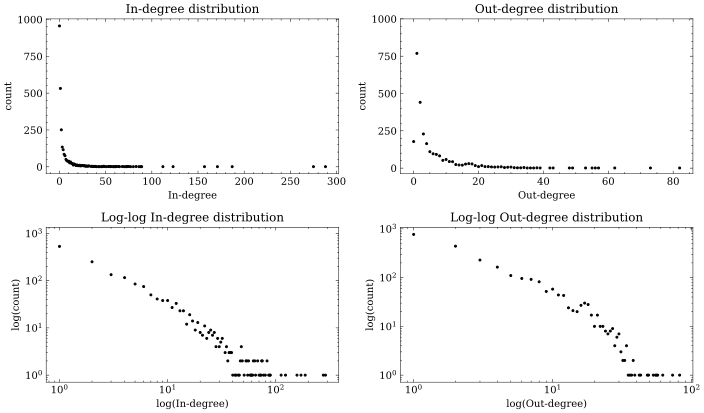

In [12]:
def get_degree_distributions(G: nx.DiGraph, degree: str="In") -> list:
        """
        Takes a graph as input and returns a list, x, that contains the different degrees,
        and an additional list, y, that contains the count of the corresponding counts.
        """
        if degree=="In":
            count = Counter([i[1] for i in list(G.in_degree())])
        elif degree=="Out":
            count = Counter([i[1] for i in list(G.out_degree())])
        count = sorted(count.items())
        x = [i[0] for i in count]
        y = [i[1] for i in count]
        return x, y

def draw_degree_distributions(G: nx.DiGraph):
    """
    Draws four plots (two log-log and two linear) based on a directed graph's
    in-degree and out-degree distributions. 
    """

    fig, axs = plt.subplots(2, 2, dpi = 120, figsize = (10,6))
    for i in range(2):
        for j, d in enumerate(["In", "Out"]):
            x, y = get_degree_distributions(G, degree = d)

            # for linear plots
            axs[i][j].plot(x, y, 'ko', markersize=2)
            axs[i][j].set_yticks(range(0, max(y)+250, 250))
            axs[i][j].set_ylabel('count')
            axs[i][j].set_xlabel(f'{d}-degree')
            axs[i][j].set_title(f'{d}-degree distribution')

            # for log-log-plots
            if i == 1:
                axs[i][j].loglog()
                axs[i][j].set_ylabel('$\log($count$)$')
                axs[i][j].set_xlabel(f'$\log(${d}-degree$)$')
                axs[i][j].set_title(f'Log-log {d}-degree distribution')

    plt.tight_layout()

draw_degree_distributions(G)


When comparing both of the linear plots with the log-log plots, it is clear that our directed network have scale-free properties. The reason for this is that the in-degree and out-degree distriubtions are well approximated by a linear model on a log-log scale suggesting that they follow a power-law distribution {cite}`barabasi2016network`. Formally the power-law distribution can be expressed as: 

$Pk \sim$ $k^{-\gamma}$

where $P_k$ is the probability that a random node links to another node, and $k$ constitutes the degree exponent {cite}`barabasi2016network` If we rewrite the expression to $Pk_{out} \sim$ $k^{-\gamma_{out}}$ and $Pk_{in} \sim$ $k^{-\gamma_{in}}$ we can calculate the exponent for both of the distributions.

In [13]:
%%capture
# We extract the exponent
in_degree_dist = [i[1] for i in G.in_degree()]
out_degree_dist = [i[1] for i in G.out_degree()]
in_degree_exp = powerlaw.Fit(in_degree_dist)
out_degree_exp = powerlaw.Fit(out_degree_dist)

In [14]:
print("The exponent of the In-degree distribution is: {}"\
      .format(in_degree_exp.power_law.alpha))
print("The exponent of the Out-degree distribution is: {}"\
      .format(out_degree_exp.power_law.alpha))

The exponent of the In-degree distribution is: 2.649729526892168
The exponent of the Out-degree distribution is: 4.909211267133928


As the exponent corresponds to the slope of the straight line in a log-log plot, this means that the out-degree distrubution to a larger degree than the in-degree distrubitions is scale-free. In pratice this entails that a few pages with a lot of links to other pages are dominating the out-degree distribution. Although a smaller exponent, we still see that this is also the case for the in-degree distribution, where some pages have a lot more pages linking to it than the rest. In the following we try to inspect some of these nodes by plotting the ones with the highest in- or out-degree.


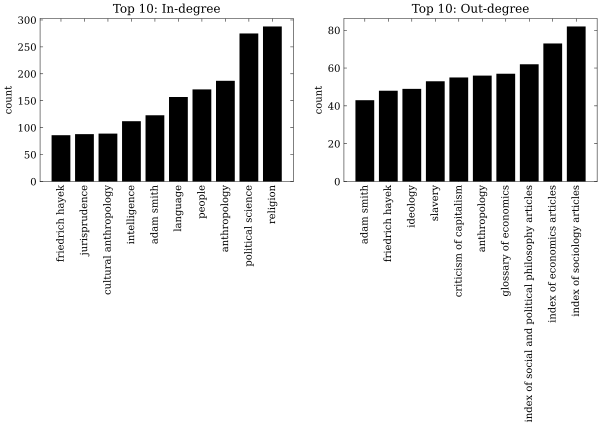

In [15]:
 def get_high_k_nodes(G: nx.DiGraph, degree: str="In", n: int=10):
    """
    Function to get the name of nodes with a high k and their corresponding k
    """
    if degree=="In":
        degree_list = sorted(G.in_degree(), key=lambda tup: tup[1], reverse=True)[0:n]
    elif degree=="Out":
        degree_list = sorted(G.out_degree(), key=lambda tup: tup[1], reverse=True)[0:n]
    x = [" ".join(i[0].split("_")) for i in degree_list]
    y = [i[1] for i in degree_list]
    x.reverse()
    y.reverse()
    return x, y

def draw_high_k_nodes(G: nx.DiGraph):
    """
    Draws two plots based on nodes in a network with a high in-degree and out-degree.
    """
    fig, axs = plt.subplots(ncols=2, dpi = 120, figsize = (10,3))
    for j, d in enumerate(["In", "Out"]):
        x, y = get_high_k_nodes(G, degree = d)
        axs[j].bar(x, y, color = "k")
        axs[j].set_ylabel('count')
        axs[j].set_xticklabels(x, rotation = 90)
        axs[j].set_title(f'Top 10: {d}-degree')
        axs[j].minorticks_off()
        
warnings.filterwarnings('ignore')  # Hide UserWarning
draw_high_k_nodes(G) 

The inspection of the pages with high degrees reveals the most central pages are what can be labelled as "metapages", that is describing social science disciplines or broad societal phenomenas such as religion or language. Naturally, a large share of the other pages refer to these, why three out of five disciplines' Wikipedia pages are among the pages with the highest in-degree. Interestingly, some of the most prominent founding fathers of economics [Friedrich Hayek](https://en.wikipedia.org/wiki/Friedrich_Hayek) and [Adam Smith](https://en.wikipedia.org/wiki/Adam_Smith) seem to be some of the most central persons to the social sciences. 


Next we visually inspect our network by drawing it. In order to enhance readability of our plot we turn the directed network into an undirected network and specify Force Atlas 2 as our layout algorithm. Furthermore we specify node sizes according to degree and colour according to discipline.

In [ ]:
%%capture
G = nx.to_undirected(G)

def change_node_names(node):
    """
    Replaces "_" to " " in node names.
    """
    return " ".join(node.split("_"))
G = nx.relabel_nodes(G, change_node_names)

# Position algorithm
forceatlas2 = ForceAtlas2(gravity=1)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Setting colours
def get_colors_palette_from_parent(G: nx.DiGraph) -> dict:
    """
    Creates a color palette given the parent attributes of the 
    nodes in a network.
    """
    disciplines = set([G.nodes[node]["parent"] for node in G.nodes()])
    col_pal = palettes.viridis(len(disciplines))
    col_pal = {parent: col_pal[key] for key, parent in enumerate(disciplines)}
    return col_pal

col_pal = get_colors_palette_from_parent(G)

def get_color_list_from_palette(G: nx.Graph, col_pal: dict=col_pal) -> list:
    """
    Creates a list of colors given the parent attribute of a node
    and its color defined in the color palette.
    """
    return [col_pal[G.nodes[i]["parent"]] for i in G.nodes]

In [ ]:
# Set toolbar and title for pot
HOVER_TOOLTIPS = [("Page", "@index"),
                  ("Discipline", "@parent")]

#Create a plot
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-1000, 1000),
              y_range=Range1d(-1000, 1000))

# Add title
plot.add_layout(Title(text='Undirected network of the weakly connected component', text_font_size="16pt"), 'above')

# Hide axis and gridlines
plot.axis.visible = False
plot.grid.grid_line_color = None

#Set positions, node size and color
G_interactive = from_networkx(G, positions, scale=1, center=(0, 0))
G_interactive.node_renderer.data_source.data['node_sizes'] = [G.degree(node) * 0.25 for node in G.nodes()]
G_interactive.node_renderer.data_source.data['node_colour'] = get_color_list_from_palette(G)
G_interactive.node_renderer.data_source.data['alpha'] = [0.75 for node in G.nodes()]
G_interactive.node_renderer.glyph = Circle(
    size="node_sizes",
    fill_color="node_colour",
    fill_alpha = "alpha")

#Set edge opacity and width
G_interactive.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=0.1)

plot.renderers.append(G_interactive)
show(plot)

In [ ]:
# Saving plot
%%capture
output_file(filename="full_network.html", title="full_network")
save(plot)

Although a bit messy, the visual inspection still reveals some properties of our network. As we already knew from the analysis of the degree distributions, metapages such as political science or anthropology are central in our network. The new information we get from this network is how clearly the different disciplines pages tend to bundle together. It seems, however, to be some inter-disciplinary variance. To gain more knowledge about our network we plot five subgraphs - one for each discipline.

In [ ]:
%%capture

# Get set of discipline nodes and based on this create 5 supgraphs
# We use sorted to keep the order of the list when transformed to a set
disciplines = [G.nodes[node]["parent"] for node in G.nodes()]
disciplines = sorted(set(disciplines), key=disciplines.index)

disciplines_graphs = {}
for d in disciplines:
    discipline_nodes = set([x for x, y in G.nodes(data=True) if y['parent']==d])
    disciplines_graphs[d] = G.subgraph(discipline_nodes)
        
# Create and store a graph object for each discipline
graphs = {}
for i, k in enumerate(disciplines_graphs.keys()):
    G = disciplines_graphs[k]
    title = f'Network for discipline: {" ".join(k.split("_"))}'
    HOVER_TOOLTIPS = [("Page", "@index")]
    
    #Create a plot
    graphs[k] = figure(tooltips = HOVER_TOOLTIPS,
                  width=500, plot_height=500,
                  tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', 
                  x_range=Range1d(-400, 400),
                  y_range=Range1d(-400, 400))
    
    # Add title
    graphs[k].add_layout(Title(text=f'Network for discipline: {" ".join(k.split("_"))}', text_font_size="12pt"), 'above')

    # Hide axis and gridlines
    graphs[k].axis.visible = False
    graphs[k].grid.grid_line_color = None    
    
    #Set positions, node size and color
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    G_interactive = from_networkx(G, positions, scale=1, center=(0, 0))
    G_interactive.node_renderer.data_source.data['node_sizes'] = [G.degree(node) * 0.25 for node in tqdm(G.nodes())]
    G_interactive.node_renderer.data_source.data['node_colour'] = get_color_list_from_palette(G)
    G_interactive.node_renderer.data_source.data['alpha'] = [0.75 for node in G.nodes()]
    G_interactive.node_renderer.glyph = Circle(
        size="node_sizes",
        fill_color="node_colour",
        fill_alpha = "alpha")

    #Set edge opacity and width
    G_interactive.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=0.1)
    graphs[k].renderers.append(G_interactive)

In [ ]:
# Plot the graphs
show(row(graphs["economics"], graphs["anthropology"]))
show(row(graphs["political_science"], graphs["psychology"]))
show(graphs["sociology"])

Once again we see that the metapages are biggest for all of the disciplines. Some of the new information that these plots provide us with is the level of intra-disciplinary clustering. Whereas sociology and anthropology, probably due to their size and our [sampling strategy](explainer_data_collection), seem to relatively be clustered, political science, economics and psycology seem to a higher degree to be split up into minor clusters. To estimate this in a more formal and systematic way we conduct [community detection](explainer_community_detection) and [topic-modelling](explainer_topic_model) in the forthcomming analysis.